In [3]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from lr_utils import load_dataset

In [4]:
train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = load_dataset()

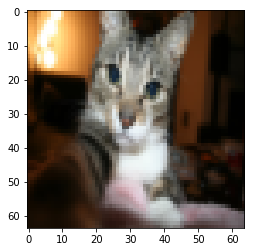

In [5]:
index = 25
plt.imshow(test_set_x_orig[index])

In [9]:
print("y=" + str(train_set_y[:,index]) + ",it's a " + classes[np.squeeze(train_set_y[:,index])].decode("utf-8") + "'picture'")

y=[1],it's a cat'picture'


In [16]:
m_train = train_set_y.shape[1] #训练集中图片的数量
m_test = test_set_y.shape[1] #测试集中图片的数量
num_px = train_set_x_orig.shape[1] #训练和测试集合图片的长度和宽度

print ("训练集的数量：m_train = " + str(m_train))
print ("测试集数量：m_test = " + str(m_test))
print ("每张图片的宽/高：num_px = " + str(num_px))
print ("每张图片的大小：(" + str(num_px) + "," + str(num_px) + ", 3)")
print ("训练集_图片的维度:"+str(train_set_x_orig.shape))
print ("训练集_标签的维度:"+str(train_set_y.shape))
print ("测试集_图片的维数: " + str(test_set_x_orig.shape))
print ("测试集_标签的维数: " + str(test_set_y.shape))

训练集的数量：m_train = 209
测试集数量：m_test = 50
每张图片的宽/高：num_px = 64
每张图片的大小：(64,64, 3)
训练集_图片的维度:(209, 64, 64, 3)
训练集_标签的维度:(1, 209)
测试集_图片的维数: (50, 64, 64, 3)
测试集_标签的维数: (1, 50)


# flattern平整化

In [17]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T #将训练集降维度并转至（209，64,64,3）至（12288,209）
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T #同上测试集变为（12288,50）

In [21]:
print ("train_set after flatten:" + str(train_set_x_flatten.shape))
print ("test_set agter flatten:" + str(test_set_x_flatten.shape))

train_set after flatten:(12288, 209)
test_set agter flatten:(12288, 50)


In [22]:
train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255

In [23]:
def sigmoid(z):
    """
    参数：z-任意大小的标量或numpy数组
    返回：s-sigmoid(z)
    """
    s = 1 / (1+np.exp(-z))
    return s

In [28]:
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(9.2) = " + str(sigmoid(9.2)))

sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922


# 初始化W and b

In [32]:
def initialze_with_zeros(dim):
    """
    此函数为w创建一个维度为（dim,1）的0向量，并将b初始化为0。
    
    参数：dim-矢量w的大小
    返回：
    - w(dim,1)
    - b- 初始化的标量对应的偏差      
    
    """
    w = np.zeros(shape = (dim , 1))
    b = 0
    #judge the data is right or not
    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b,int))
    
    return (w,b)

# propagate function

In [50]:
def propagate(w,b,X,Y):
    """
    
    实现前向和后向传播的成本函数其梯度。
    参数：
        w - 权重，大小不等的数组（num_px * num_px * 3,1）
        b - 偏差，一个标量
        X - 矩阵类型为（num_px * num_px * 3, 训练数量）
        Y - 真正的标签 矢量（非猫为零，是猫为1），矩阵维度（1，训练数目）
    返回：
        cost - 逻辑回归的负对数似然成本
        dw - 相对w的损失梯度，形状与w相同
        db - 相对b的损失梯度，形状与b相同
    """
    m = X.shape[1]
    #propagate
    A = sigmoid(np.dot(w.T,X) + b)#计算激活值
    cost = (-1 / m) * np.sum(Y * np.log(A) + (1-Y) * (np.log(1 - A)))
    
    #反向传播
    dw = (1 / m) * np.dot(X ,(A - Y).T)#参看视频中的偏导公式
    db = (1 / m) * np.sum(A-Y)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape ==())
    
    #storage dw and db by a dictionary
    
    grads = {
        "dw":dw,
        "db":db
    }
    return (grads,cost)

In [51]:
def optimize(w , b , X , Y , num_iterations , learning_rate , print_cost = False):
    """
    此函数通过运行梯度下降算法来优化w和b

    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 维度为（num_px * num_px * 3，训练数据的数量）的数组。
        Y  - 真正的“标签”矢量（如果非猫则为0，如果是猫则为1），矩阵维度为(1,训练数据的数量)
        num_iterations  - 优化循环的迭代次数
        learning_rate  - 梯度下降更新规则的学习率
        print_cost  - 每100步打印一次损失值

    返回：
        params  - 包含权重w和偏差b的字典
        grads  - 包含权重和偏差相对于成本函数的梯度的字典
        成本 - 优化期间计算的所有成本列表，将用于绘制学习曲线。

    提示：
    我们需要写下两个步骤并遍历它们：
        1）计算当前参数的成本和梯度，使用propagate（）。
        2）使用w和b的梯度下降法则更新参数。
    """

    costs = []

    for i in range(num_iterations):

        grads, cost = propagate(w, b, X, Y)

        dw = grads["dw"]
        db = grads["db"]

        w = w - learning_rate * dw
        b = b - learning_rate * db

        #记录成本
        if i % 100 == 0:
            costs.append(cost)
        #打印成本数据
        if (print_cost) and (i % 100 == 0):
            print("迭代的次数: %i ， 误差值： %f" % (i,cost))

    params  = {
                "w" : w,
                "b" : b }
    grads = {
            "dw": dw,
            "db": db } 
    return (params , grads , costs)

In [52]:
def predict(w , b , X ):
    """
    使用学习逻辑回归参数logistic （w，b）预测标签是0还是1，

    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 维度为（num_px * num_px * 3，训练数据的数量）的数据

    返回：
        Y_prediction  - 包含X中所有图片的所有预测【0 | 1】的一个numpy数组（向量）

    """

    m  = X.shape[1] #图片的数量
    Y_prediction = np.zeros((1,m)) 
    w = w.reshape(X.shape[0],1)

    #计预测猫在图片中出现的概率
    A = sigmoid(np.dot(w.T , X) + b)
    for i in range(A.shape[1]):
        #将概率a [0，i]转换为实际预测p [0，i]
        Y_prediction[0,i] = 1 if A[0,i] > 0.5 else 0
    #使用断言
    assert(Y_prediction.shape == (1,m))

    return Y_prediction

In [53]:
def model(X_train , Y_train , X_test , Y_test , num_iterations = 2000 , learning_rate = 0.5 , print_cost = False):
    """
    通过调用之前实现的函数来构建逻辑回归模型

    参数：
        X_train  - numpy的数组,维度为（num_px * num_px * 3，m_train）的训练集
        Y_train  - numpy的数组,维度为（1，m_train）（矢量）的训练标签集
        X_test   - numpy的数组,维度为（num_px * num_px * 3，m_test）的测试集
        Y_test   - numpy的数组,维度为（1，m_test）的（向量）的测试标签集
        num_iterations  - 表示用于优化参数的迭代次数的超参数
        learning_rate  - 表示optimize（）更新规则中使用的学习速率的超参数
        print_cost  - 设置为true以每100次迭代打印成本

    返回：
        d  - 包含有关模型信息的字典。
    """
    w , b = initialze_with_zeros(X_train.shape[0])

    parameters , grads , costs = optimize(w , b , X_train , Y_train,num_iterations , learning_rate , print_cost)

    #从字典“参数”中检索参数w和b
    w , b = parameters["w"] , parameters["b"]

    #预测测试/训练集的例子
    Y_prediction_test = predict(w , b, X_test)
    Y_prediction_train = predict(w , b, X_train)

    #打印训练后的准确性
    print("训练集准确性："  , format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100) ,"%")
    print("测试集准确性："  , format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100) ,"%")

    d = {
            "costs" : costs,
            "Y_prediction_test" : Y_prediction_test,
            "Y_prediciton_train" : Y_prediction_train,
            "w" : w,
            "b" : b,
            "learning_rate" : learning_rate,
            "num_iterations" : num_iterations }
    return d

In [54]:
print("====================测试model====================")     
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

====================测试model====================
迭代的次数: 0 ， 误差值： 0.693147
迭代的次数: 100 ， 误差值： 0.584508
迭代的次数: 200 ， 误差值： 0.466949
迭代的次数: 300 ， 误差值： 0.376007
迭代的次数: 400 ， 误差值： 0.331463
迭代的次数: 500 ， 误差值： 0.303273
迭代的次数: 600 ， 误差值： 0.279880
迭代的次数: 700 ， 误差值： 0.260042
迭代的次数: 800 ， 误差值： 0.242941
迭代的次数: 900 ， 误差值： 0.228004
迭代的次数: 1000 ， 误差值： 0.214820
迭代的次数: 1100 ， 误差值： 0.203078
迭代的次数: 1200 ， 误差值： 0.192544
迭代的次数: 1300 ， 误差值： 0.183033
迭代的次数: 1400 ， 误差值： 0.174399
迭代的次数: 1500 ， 误差值： 0.166521
迭代的次数: 1600 ， 误差值： 0.159305
迭代的次数: 1700 ， 误差值： 0.152667
迭代的次数: 1800 ， 误差值： 0.146542
迭代的次数: 1900 ， 误差值： 0.140872
训练集准确性： 99.04306220095694 %
测试集准确性： 70.0 %


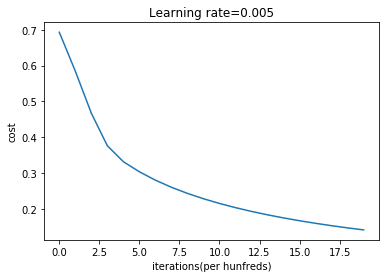

In [56]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations(per hunfreds)')
plt.title("Learning rate=" + str(d["learning_rate"]))
plt.show()

learning rate is: 0.01
训练集准确性： 99.52153110047847 %
测试集准确性： 68.0 %

-------------------------------------------------------

learning rate is: 0.001
训练集准确性： 88.99521531100478 %
测试集准确性： 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
训练集准确性： 68.42105263157895 %
测试集准确性： 36.0 %

-------------------------------------------------------



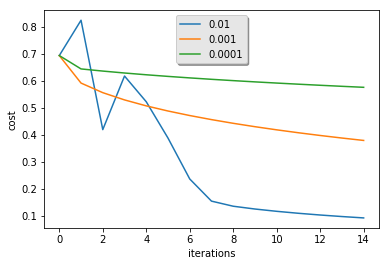

In [57]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()